## **Mount to drive and cd to repo**

In [2]:
%cd '/content/drive/MyDrive/sentiment_analysis'

/content/drive/MyDrive/sentiment_analysis


In [3]:
!pip install datasketch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 2.2 MB/s eta 0:00:00


In [4]:
!pip install transformers


## **Load data and do some basic analysis to understand data**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('clean_sample_data.csv')
test = pd.read_csv('test_data.csv')

In [6]:
print(df.columns)
df['Clean_Review'].values[0]

Index(['overall', 'reviewText', 'Clean_Review'], dtype='object')


'incredible company place product market buggy this.\n\nbought family pack instal first computer configure backup computer even backup fails everything green main dashboard.\na simple change parameter backup possible without corrupt backups.\nbackup network server work ti keep fail connect server even configure backup problem access server.\nbackup network server take eternity network usage crash backup configuration corruption.\n\nthis software unusable buy look alternative'

In [7]:
print(df.shape)

(3354, 3)


In [8]:
df.head()

overall                                         reviewText  \
0      1.0  It is incredible that in 2014 a company can pl...   
1      1.0  I am afraid to install it on my system,I have ...   
2      1.0  I upgraded to X2 thinking that the bugs had be...   
3      1.0  The tech specs say that Windows XP Pro is suff...   
4      1.0  Why did we have to do away with the good old d...   

                                        Clean_Review  
0  incredible company place product market buggy ...  
1  afraid install systemi bit window os...system ...  
2  upgraded thinking bug work software take forev...  
3  tech spec say window xp pro sufficient wrong w...  
4  away good old disc great booster norton use si...

## **Quick Data Analysis**

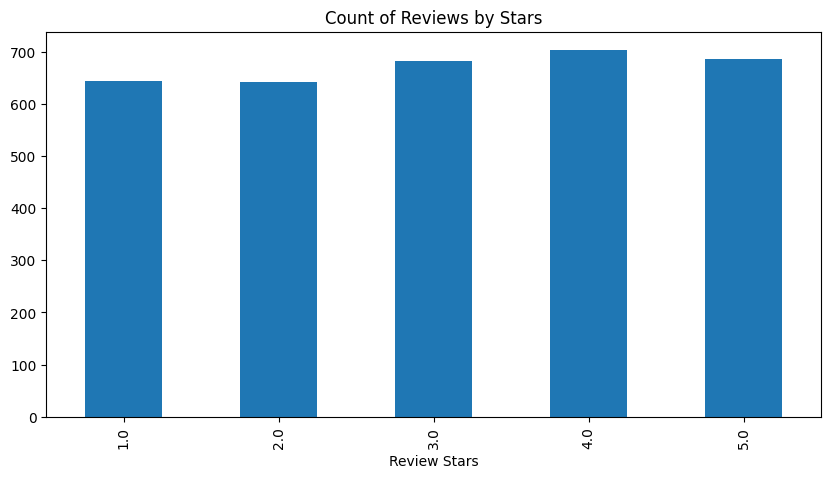

In [9]:
ax = df['overall'].value_counts().sort_index().plot(kind='bar',title='Count of Reviews by Stars',
                                               figsize=(10,5))
ax.set_xlabel('Review Stars')
plt.show()

## **NLTK Set Up**

In [10]:
import nltk
nltk.download('punkt')

# loop over each line of the DataFrame，tokenize each line
tokenized_texts = df['reviewText'].apply(lambda x: nltk.word_tokenize(str(x)))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **Extracting embedding 2 methods: Word2Vec and Bert**

In [26]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)
word_vectors = model.wv

In [12]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [13]:
import torch

def encode_sentences(sentences, max_length=512):
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
                            sent,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            truncation=True,
                            return_attention_mask=True,
                            return_tensors='pt',
                        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks


# Example usage
input_ids, attention_masks = encode_sentences(df)
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_masks)

# `outputs` is a tuple, we only need the first element, which contains
# the embeddings.
embeddings = outputs[0]



# **Three Clustering Algorithms**


## ***Clustering algorithms in our own code***

###KMeans our code, Word2Vec embeddings as example

In [21]:
import random

def initialize_centroids(points, k):
    """Randomly initialize centroids"""
    centroids = points.copy()
    random.shuffle(centroids)
    return centroids[:k]

def closest_centroid(points, centroids):
    """Find the closest centroid for each point"""
    distances = [[sum([(point[dim] - centroid[dim]) ** 2 for dim in range(len(point))]) for centroid in centroids] for point in points]
    return [distances[i].index(min(distances[i])) for i in range(len(distances))]

def recompute_centroids(points, closest, centroids):
    """Recompute centroids"""
    new_centroids = []
    for i in range(len(centroids)):
        assigned_points = [points[j] for j in range(len(points)) if closest[j] == i]
        if assigned_points:
            new_centroids.append([sum(dim)/len(assigned_points) for dim in zip(*assigned_points)])
        else:
            new_centroids.append(centroids[i])
    return new_centroids

def centroids_converged(new_centroids, old_centroids, threshold=0.001):
    """Check if the centroids have converged"""
    for new_centroid, old_centroid in zip(new_centroids, old_centroids):
        if sum((nc - oc)**2 for nc, oc in zip(new_centroid, old_centroid)) > threshold:
            return False
    return True

def kmeans(points, k, max_iterations=100):
    """Main kmeans algorithm"""
    centroids = initialize_centroids(points, k)
    for _ in range(max_iterations):
        closest = closest_centroid(points, centroids)
        new_centroids = recompute_centroids(points, closest, centroids)

        if centroids_converged(new_centroids, centroids):
            break

        centroids = new_centroids
    return closest


k = 3
clusters = kmeans(word_vectors.vectors, k)
print(clusters)



[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

###DBSCAN our own codes, Word2Vec embeddings as example. **(warning:need more than 60mins in our large dataset)**

In [27]:
import numpy as np

def euclidean_distance(point1, point2):
    """Calculate Euclidean distance between two numpy array points."""
    return np.sqrt(np.sum((point1 - point2) ** 2))

def region_query(data, point_idx, eps):
    """Find points within eps distance of the given point."""
    point = data[point_idx]
    return [idx for idx, p in enumerate(data) if euclidean_distance(point, p) < eps]

def expand_cluster(data, classifications, point_idx, cluster_id, eps, min_points):
    """Expand the cluster from the seed point."""
    seeds = region_query(data, point_idx, eps)
    if len(seeds) < min_points:
        classifications[point_idx] = 'Noise'
        return False
    else:
        classifications[point_idx] = cluster_id
        for seed_idx in seeds:
            if classifications[seed_idx] == 'Unvisited':
                classifications[seed_idx] = cluster_id
                seeds.extend(region_query(data, seed_idx, eps))

        seeds = list(set(seeds))  # Remove duplicates
        return True

def dbscan(data, eps, min_points):
    """DBSCAN algorithm implementation."""
    cluster_id = 1
    classifications = {idx: 'Unvisited' for idx in range(len(data))}
    for idx in range(len(data)):
        if classifications[idx] == 'Unvisited':
            if expand_cluster(data, classifications, idx, cluster_id, eps, min_points):
                cluster_id += 1
    return classifications

# Example Usage
eps = 3
min_points = 2
print(word_vectors.vectors)
print(dbscan(word_vectors.vectors, eps, min_points))


[[ 1.06136858e+00  6.10521913e-01  8.30503583e-01 ... -2.18322563e+00
   8.71779978e-01 -6.96982503e-01]
 [-4.32760298e-01 -4.93196249e-02  5.87946117e-01 ... -1.32925999e+00
   8.77784416e-02  3.69975895e-01]
 [-2.99495637e-01 -5.63642144e-01 -4.77578081e-02 ...  1.11935221e-01
   1.38402617e+00  4.42883104e-01]
 ...
 [-1.27053084e-02 -6.20208168e-03  1.32036600e-02 ... -2.40517291e-03
  -1.04981298e-02  2.06504893e-02]
 [ 1.20722195e-02 -1.18435817e-02  6.50558714e-03 ... -1.12645831e-02
  -1.54766310e-02  3.16672609e-03]
 [ 7.35661015e-03  5.21969656e-03  2.18033951e-04 ...  3.05460417e-05
  -1.14456546e-02 -9.63006448e-03]]


KeyboardInterrupt: ignored

### CURE our own code, Word2Vec as example

In [32]:
import numpy as np
import random

def euclidean_distance(point1, point2):
    """Calculate Euclidean distance between two points."""
    return np.sqrt(np.sum((point1 - point2) ** 2))

def hierarchical_clustering(data, n_clusters):
    """Perform simple hierarchical clustering to initialize centroids."""
    centroids = data[np.random.choice(data.shape[0], n_clusters, replace=False)]
    return centroids

def select_representatives(data, centroids, n_representatives, shrink_factor):
    """Select and shrink representatives for each cluster."""
    representatives = {}
    for idx, centroid in enumerate(centroids):
        distances = np.array([euclidean_distance(point, centroid) for point in data])
        furthest_points = data[np.argsort(distances)[-n_representatives:]]
        representatives[idx] = centroid + shrink_factor * (furthest_points - centroid)
    return representatives

def assign_clusters(data, representatives):
    """Assign each data point to the nearest representative."""
    cluster_assignments = np.zeros(len(data))
    for i, point in enumerate(data):
        nearest_cluster = min(representatives.keys(), key=lambda k: euclidean_distance(point, np.mean(representatives[k], axis=0)))
        cluster_assignments[i] = nearest_cluster
    return cluster_assignments

def cure_clustering(data, n_clusters, n_representatives, shrink_factor):
    """CURE algorithm implementation."""
    centroids = hierarchical_clustering(data, n_clusters)
    representatives = select_representatives(data, centroids, n_representatives, shrink_factor)
    return assign_clusters(data, representatives)

# Example Usage
data = word_vectors.vectors
n_clusters = 3
n_representatives = 5
shrink_factor = 0.5
clusters = cure_clustering(data, n_clusters, n_representatives, shrink_factor)
print(clusters)


[1. 0. 1. ... 2. 2. 2.]


# **Clustering Results**

##Word2Vec Clustering results

In [37]:
from sklearn.cluster import KMeans,DBSCAN
### KMeans
kmeans = KMeans(n_clusters=3)
# Fit the model
X_KMeans = word_vectors.vectors
kmeans.fit(X_KMeans)
# Getting the cluster labels
KMeans_clusters = kmeans.labels_
print("KMeans Cluster assignments:", KMeans_clusters)

### DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=2)

X_DBSCAN = word_vectors.vectors
DBSCAN_clusters = dbscan.fit_predict(X_DBSCAN)

# Output the cluster assignments
print("DBSCAN Cluster assignments:", DBSCAN_clusters)

### CURE
X_CURE = word_vectors.vectors
n_clusters = 3
n_representatives = 5
shrink_factor = 0.5
CURE_clusters = cure_clustering(X_CURE, n_clusters, n_representatives, shrink_factor)
print("CURE Cluster assignments:", CURE_clusters)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans Cluster assignments: [1 1 1 ... 0 0 0]
DBSCAN Cluster assignments: [-1 -1 -1 ...  2  2  2]
CURE Cluster assignments: [0. 0. 0. ... 1. 1. 1.]


##Bert Embeddings Clustering results

In [ ]:
averaged_embeddings = embeddings.mean(dim=0).detach().numpy()

# Define the number of clusters
num_clusters = 3

### KMeans
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(averaged_embeddings)
labels = kmeans.labels_
print(labels)
### DBSCAN

### CURE

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 1 0 1 1 0 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1
 0 0 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 1 0 0
 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 1 0 0 2 1 1 0 0 1 1 1
 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 1 1 0 0
 0 0 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1
 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 2 2 0 2 1 1 1 0 0 1 0 1 1 0 0 1 1 2 2 2 1 0
 0 1 1 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 0 0 2 2 1 2 0 0 2 2 1 1 0 0 0 0 0
 0 2 2 2 2 2 2 2 2 1 1 0 0 2 2 2 2 2 2 2 2 2 2 2 2 1 2 0 0 0 1 1 0 0 0 0 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 1 0 0 0 2 2 2 2 0 2 2 1 1 1 0 0 1 0 1 0 0 2 2
 2 2 2 2 2 2 0 2 2 1 1 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 1 0 0 0 1 2 0 0 2 0 2 2 2 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1
 0 0 1 1 1 0 2 1 0 0 1 0 0 0 0 1 0 0 0 1 0 2 2 2 2 2 2 1 0 2 2 2 2 2 2 2 0
 2 2 2 2 0 2 2 1 0 0 0 1 1 1 0 0 0 0 0 2 2 2 2 2 2 2 2 2 0 0 1 0 0 2 2 2 2
 2 2 2 2 2 1 1 0 0 0 1 1 

# **Visualize clustering results**

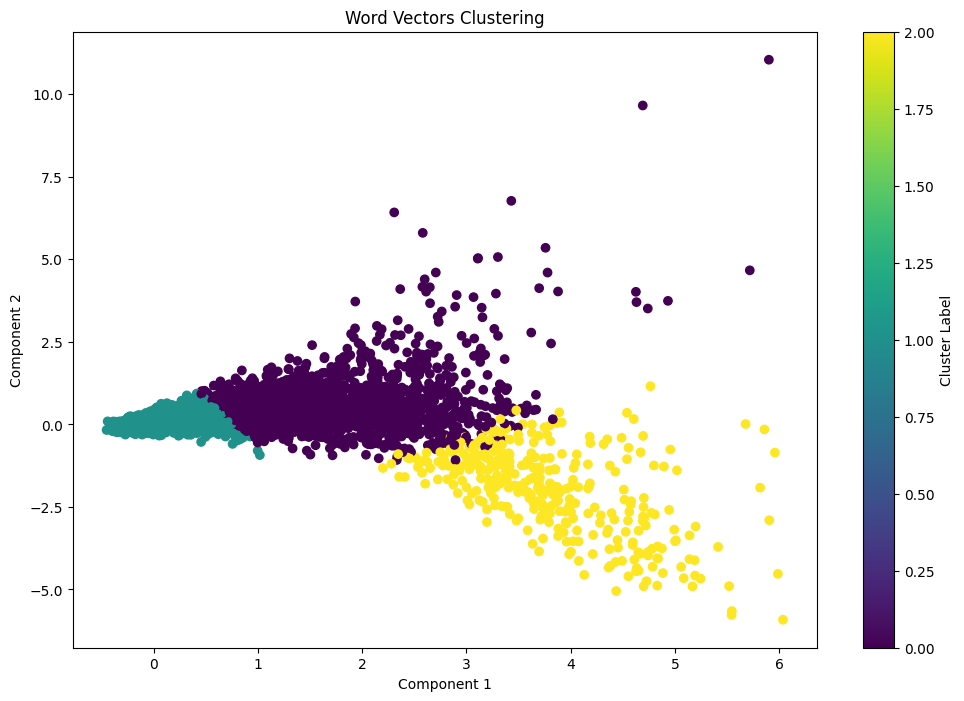

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(X_KMeans)
plt.figure(figsize=(12, 8))
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('Word Vectors Clustering')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


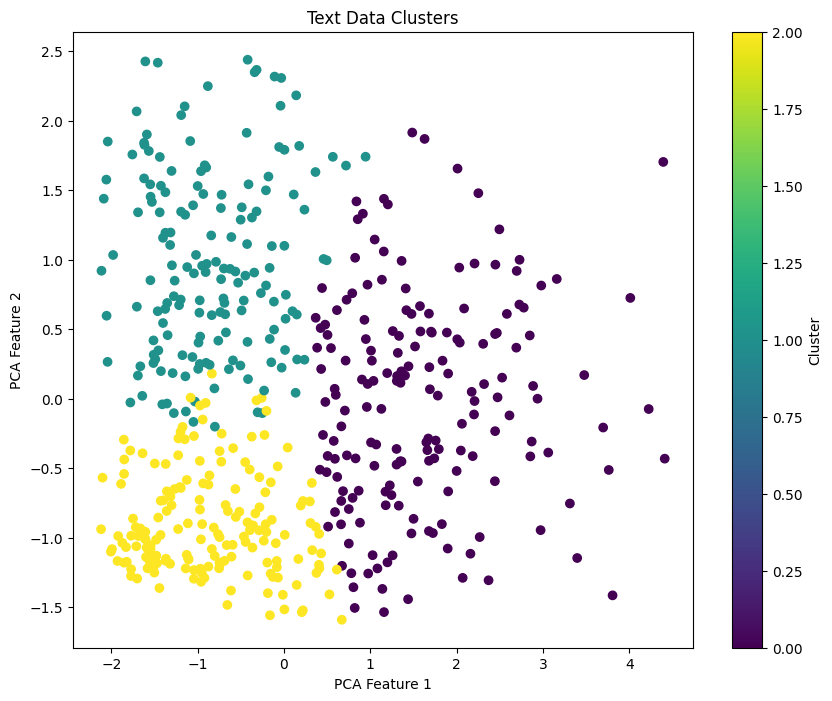

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(averaged_embeddings)  # or pooled_embeddings

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis')
plt.title('Text Data Clusters')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar(label='Cluster')
plt.show()



# **Map clusters to sentiment labels**

In [ ]:
from collections import Counter
import re


def get_most_common_words(texts, top_n=10):
    word_counts = Counter()
    for text in texts:
        word_counts.update(tokenized_texts.split())
    return word_counts.most_common(top_n)

# Example data
texts = tokenized_texts

cluster_assignments = labels  # Cluster assignments for each text

# Group texts by clusters
clustered_texts = {i: [] for i in range(3)}  # Assuming 3 clusters
for text, cluster in zip(texts, cluster_assignments):
    clustered_texts[cluster].append(text)

# Analyze frequent words in each cluster
frequent_words_by_cluster = {cluster: get_most_common_words(texts) for cluster, texts in clustered_texts.items()}

# Infer sentiment labels
# This is a manual process based on the frequent words
sentiment_labels = {
    0: "Positive",  # Example, assuming cluster 0 is positive
    1: "Negative",  # Example, assuming cluster 1 is negative
    2: "Neutral"    # Example, assuming cluster 2 is neutral
}

# Print frequent words and inferred sentiment for each cluster
for cluster, words in frequent_words_by_cluster.items():
    print(f"Cluster {cluster} (Inferred Sentiment: {sentiment_labels[cluster]}):")
    print(", ".join([word for word, _ in words]))
    print()


# **Evaluate Methods using test dataset**

In [ ]:
print(test.columns)

print(test.shape)

In [ ]:
test.head()

In [ ]:
test_data = test['reviewText'].apply(lambda x: nltk.word_tokenize(str(x)))